In [ ]:
# Kng Yew Chian, October 2023
# Using the Apriori Algorithm, mine the frequent itemsets from grocery or ecommerce data (e.g. rolls/buns and yoghurt are often purchased together)
# Visualize Consumer groups with hierarchical clustering : Consumers that have similar frequent itemsets are likely to be grouped together
# The purpose of data mining here is to extract the important information from the purchase histories without using all the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import itertools
from mlxtend.preprocessing import TransactionEncoder
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE

# Task 1
Low memory implementation of apriori

In [ ]:
# Set chunk size using num_rows to determine how much of the file to read at once
num_rows = 100000
def read_csv(file_name):
  for chunk in pd.read_csv(file_name, chunksize=num_rows):
    yield chunk

#Apriori algo w disk - takes in the filename of the 1 hot csv of the dataframe of transactions, minimum support as a ratio, then generates all frequent itemsets with support >= minsup
def apriori_low_mem(dataset, minsup):
  transactions = 0
  k = 1
  f = []
  # generate f1
  data = next(read_csv(dataset))
  f1 = pd.DataFrame(0, index=[0], columns=data.columns)

  for data in read_csv(dataset):
    # print("data")
    # print(data)
    for (column_name, rows) in data.iteritems():
      f1[column_name] += rows.agg(sum)
    transactions += len(data)
  for (column_name, rows) in f1.iteritems():
    f1[column_name] = f1[column_name]/transactions
  f1 = [frozenset([item]) for item in f1.columns if f1[item][0]>= minsup]
  f.append(f1)

  # print("transactions:", transactions)

  while len(f[k-1])>0:
    # generate f Generate Ck+1 from Fk
    fk_1 = f[k-1]
    ck = set()
    # add all candidate sets via k-1*k-1
    for x in range(len(fk_1)):
      for y in range(len(fk_1)-x-1):
        if len(fk_1[x].union(fk_1[x+y+1])) == len(fk_1[x])+1:
          ck.add(frozenset(fk_1[x].union(fk_1[x+y+1])))
    # print("CK+1")
    # print(ck)

    # Prune candidate itemsets in Ck+1 containing subsets of length k that are infrequent
    ck_removed = []
    for itemset in ck:
      subsets = list(itertools.combinations(itemset, len(itemset)-1))
      for x in subsets:
        if set(x) not in fk_1:
          ck_removed.append(itemset)
          break
    ck = ck-set(ck_removed)
    # print("removed: ")
    # print(ck_removed)
    # print("remaining: ")
    # print(ck)

    # Count the support of each candidate in Ck+1 by scanning the DB
    support = {x: 0 for x in ck}
    for data in read_csv(dataset):
      for candidate_set in support.keys():
        support_transactions = data.query(' and '.join(['`{0}`==True'.format(item) for item in candidate_set]))[candidate_set]
        # print(support_transactions)
        support[candidate_set] += len(support_transactions)
    for candidate_set in support.keys():
      support[candidate_set] = support[candidate_set]/transactions

    # Eliminate candidates in Ck+1 that are infrequent, leaving only those that are frequent => Fk+1
    fk_1 = [candidate_set for candidate_set in support.keys() if support[candidate_set]>=minsup]
    f.append(fk_1)
    k += 1
  return [item for sets in f for item in sets]

In [ ]:
#mlxtend can convert into 1 hot encoding for us
from mlxtend.preprocessing import TransactionEncoder
source_file = open("/content/Groceries dataset.csv", encoding="utf8", newline='')
test = pd.read_csv(source_file)
test1 = test.groupby("Member_number", as_index=False).aggregate({"itemDescription": lambda x: list(set(x))})
te = TransactionEncoder()
te_ary = te.fit(test1["itemDescription"]).transform(test1["itemDescription"])
df = pd.DataFrame(te_ary, columns=te.columns_)
df.to_csv("Groceries dataset processed.csv", index = False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
processed = pd.read_csv(open("/content/Groceries dataset processed.csv", encoding="utf8", newline=''))
processed

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
1,False,False,False,False,False,False,False,False,True,False,...,False,False,False,True,False,True,False,True,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3893,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3894,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,False
3895,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3896,False,False,False,False,False,False,False,False,False,True,...,False,False,False,True,False,False,False,False,True,False


In [ ]:
frequent_itemsets1 = apriori_low_mem("Groceries dataset processed.csv", 0.1)
frequent_itemsets1

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-76-61ccd0e5f776>:19: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for (column_name, rows) in data.iteritems():
<ipython-input-76-61ccd0e5f776>:22: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for (column_name, rows) in f1.iteritems():


[frozenset({'beef'}),
 frozenset({'bottled beer'}),
 frozenset({'bottled water'}),
 frozenset({'brown bread'}),
 frozenset({'butter'}),
 frozenset({'canned beer'}),
 frozenset({'chicken'}),
 frozenset({'citrus fruit'}),
 frozenset({'coffee'}),
 frozenset({'curd'}),
 frozenset({'domestic eggs'}),
 frozenset({'frankfurter'}),
 frozenset({'frozen vegetables'}),
 frozenset({'fruit/vegetable juice'}),
 frozenset({'margarine'}),
 frozenset({'newspapers'}),
 frozenset({'other vegetables'}),
 frozenset({'pastry'}),
 frozenset({'pip fruit'}),
 frozenset({'pork'}),
 frozenset({'rolls/buns'}),
 frozenset({'root vegetables'}),
 frozenset({'sausage'}),
 frozenset({'shopping bags'}),
 frozenset({'soda'}),
 frozenset({'tropical fruit'}),
 frozenset({'whipped/sour cream'}),
 frozenset({'whole milk'}),
 frozenset({'yogurt'}),
 frozenset({'sausage', 'whole milk'}),
 frozenset({'root vegetables', 'whole milk'}),
 frozenset({'bottled water', 'whole milk'}),
 frozenset({'rolls/buns', 'soda'}),
 frozenset({

Compare against mlxtend's library apriori function

In [ ]:
from mlxtend.frequent_patterns import apriori
frequent_itemsets2 = apriori(processed, min_support=0.1, use_colnames=True)
frequent_itemsets2

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,support,itemsets
0,0.119548,(beef)
1,0.158799,(bottled beer)
2,0.213699,(bottled water)
3,0.135967,(brown bread)
4,0.126475,(butter)
5,0.165213,(canned beer)
6,0.100564,(chicken)
7,0.185480,(citrus fruit)
8,0.114931,(coffee)
9,0.120831,(curd)


In [ ]:
list1 = frequent_itemsets1
list2 = list(frequent_itemsets2["itemsets"])
i=set.intersection(set(list1),set(list2))
if len(i) > 0:
    print('duplicates found')
    print(f"There are {len(i)} itemsets in common.")
    print(f"There are {len(list1)} itemsets in our apriori algorithm.")
    print(f"There are {len(list2)} itemsets in mlxtend's apriori algorithm.")
else:
    print('no duplicates found')

duplicates found
There are 42 itemsets in common.
There are 42 itemsets in our apriori algorithm.
There are 42 itemsets in mlxtend's apriori algorithm.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Task 2
Running Apriori on different datasets with differing min-support threshold

Groceries dataset

In [ ]:
source_file = open("/content/Groceries processed.csv")
groceries = pd.read_csv(source_file)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
1,False,False,False,False,False,False,False,False,True,False,...,False,False,False,True,False,True,False,True,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3893,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3894,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,False
3895,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3896,False,False,False,False,False,False,False,False,False,True,...,False,False,False,True,False,False,False,False,True,False


In [ ]:
#testing mlxtend apriori
from mlxtend.frequent_patterns import apriori
frequent_itemsets = apriori(test3, min_support = 0.05, use_colnames = True)
frequent_itemsets #itemsets are frozensets which are immutable sets

NameError: ignored

Market Basket Dataset

Ecommerce Dataset

# Task 3
Perform clustering on the Groceries and Market Basket datasets.

In [ ]:
#Getting frequent itemset for Market Basket using mlxtend's apriori function.
market_basket_df = pd.read_csv("Market Basket dataset.csv", sep=';')
market_basket = market_basket_df.groupby(['CustomerID','Country','BillNo'], as_index=False).aggregate({"Itemname": lambda x: list(set(x))})
te = TransactionEncoder()
te_ary = te.fit(market_basket["Itemname"]).transform(market_basket["Itemname"])
te_ary = te_ary.astype("int") #convert to binary (1s and 0s)
market_basket_onehot_df = pd.DataFrame(te_ary, columns=te.columns_) #one hot encoding of items

market_basket_frequent_itemsets = apriori(market_basket_onehot_df, min_support = 0.05, use_colnames = True)

In [ ]:
#Clustering of market basket dataset using K-Means
market_basket = pd.concat([market_basket, market_basket_onehot_df], axis=1) #combining the one hot encoding of items with market basket dataframe

market_basket_frequent_itemsets_list = []

for index,value in market_basket_frequent_itemsets['itemsets'].items():
  market_basket_frequent_itemsets_list.append(list(value))#converting frequent itemsets to a list

market_basket_final_df = market_basket.loc[market_basket['Itemname'].isin(market_basket_frequent_itemsets_list)] #take out rows of transactions which are frequent

market_basket_final = market_basket_final_df[['CustomerID','Country','BillNo','Itemname']]
columns = market_basket_final_df.columns.drop(['CustomerID','Country','BillNo','Itemname'])
market_basket_final['Frequent Itemset Encodings'] = market_basket_final_df[columns].apply(lambda row:row.tolist(), axis = 1) #combining the columns of one hot encoding of items into a single list for each transaction

X = market_basket_final['Frequent Itemset Encodings'].apply(pd.Series).values # Convert binary lists to numpy array suitable as input for kmeans

from sklearn.cluster import KMeans
# Choose the number of clusters (k)
k = 10
# Perform k-means clustering
kmeans = KMeans(n_clusters=k, random_state=42)
market_basket_final.loc[:,'Clusters'] = kmeans.fit_predict(X)

Apriori on groceries dataset

In [ ]:
#Getting frequent itemset for Groceries using disk-based apriori function.

groceries_df = pd.read_csv("/content/drive/MyDrive/groceries_dataset.csv")
groceries = groceries_df.groupby("Member_number", as_index=False).aggregate({"itemDescription": lambda x: list(set(x))})
te = TransactionEncoder()
te_ary = te.fit(groceries["itemDescription"]).transform(groceries["itemDescription"])
te_ary = te_ary.astype("int") #convert to binary (1s and 0s)
groceries_onehot_df = pd.DataFrame(te_ary, columns=te.columns_) # needed for hierarchical clustering
groceries_onehot_df.to_csv("/content/drive/MyDrive/groceries_onehot.csv")

groceries_minsup_list = [0.06, 0.10, 0.14]
groceries_frequent_itemsets_per_minsup = []
for minsup in groceries_minsup_list:
  groceries_frequent_itemsets_per_minsup.append(apriori_low_mem("/content/drive/MyDrive/groceries_onehot.csv", minsup))

<ipython-input-4-61ccd0e5f776>:19: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for (column_name, rows) in data.iteritems():
<ipython-input-4-61ccd0e5f776>:22: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for (column_name, rows) in f1.iteritems():
<ipython-input-4-61ccd0e5f776>:19: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for (column_name, rows) in data.iteritems():
<ipython-input-4-61ccd0e5f776>:22: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for (column_name, rows) in f1.iteritems():
<ipython-input-4-61ccd0e5f776>:19: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for (column_name, rows) in data.iteritems():
<ipython-input-4-61ccd0e5f776>:22: FutureWarning: iteritems is deprecated and will be removed 

Groceries dataset
Hierarchical Clustering

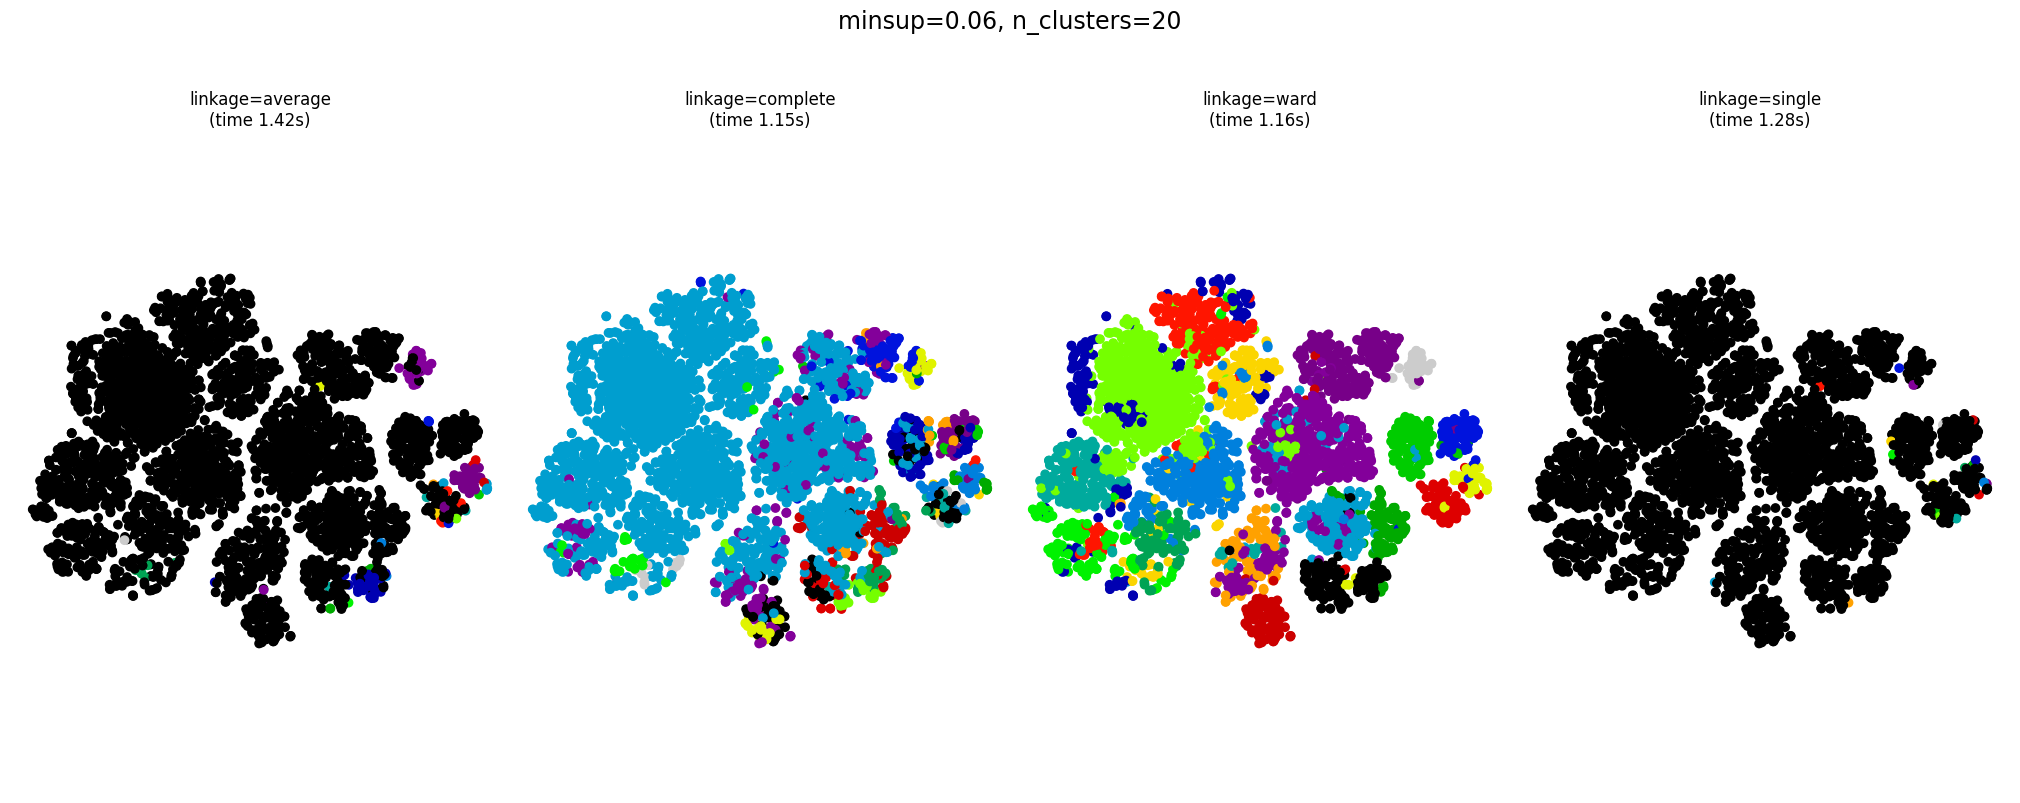

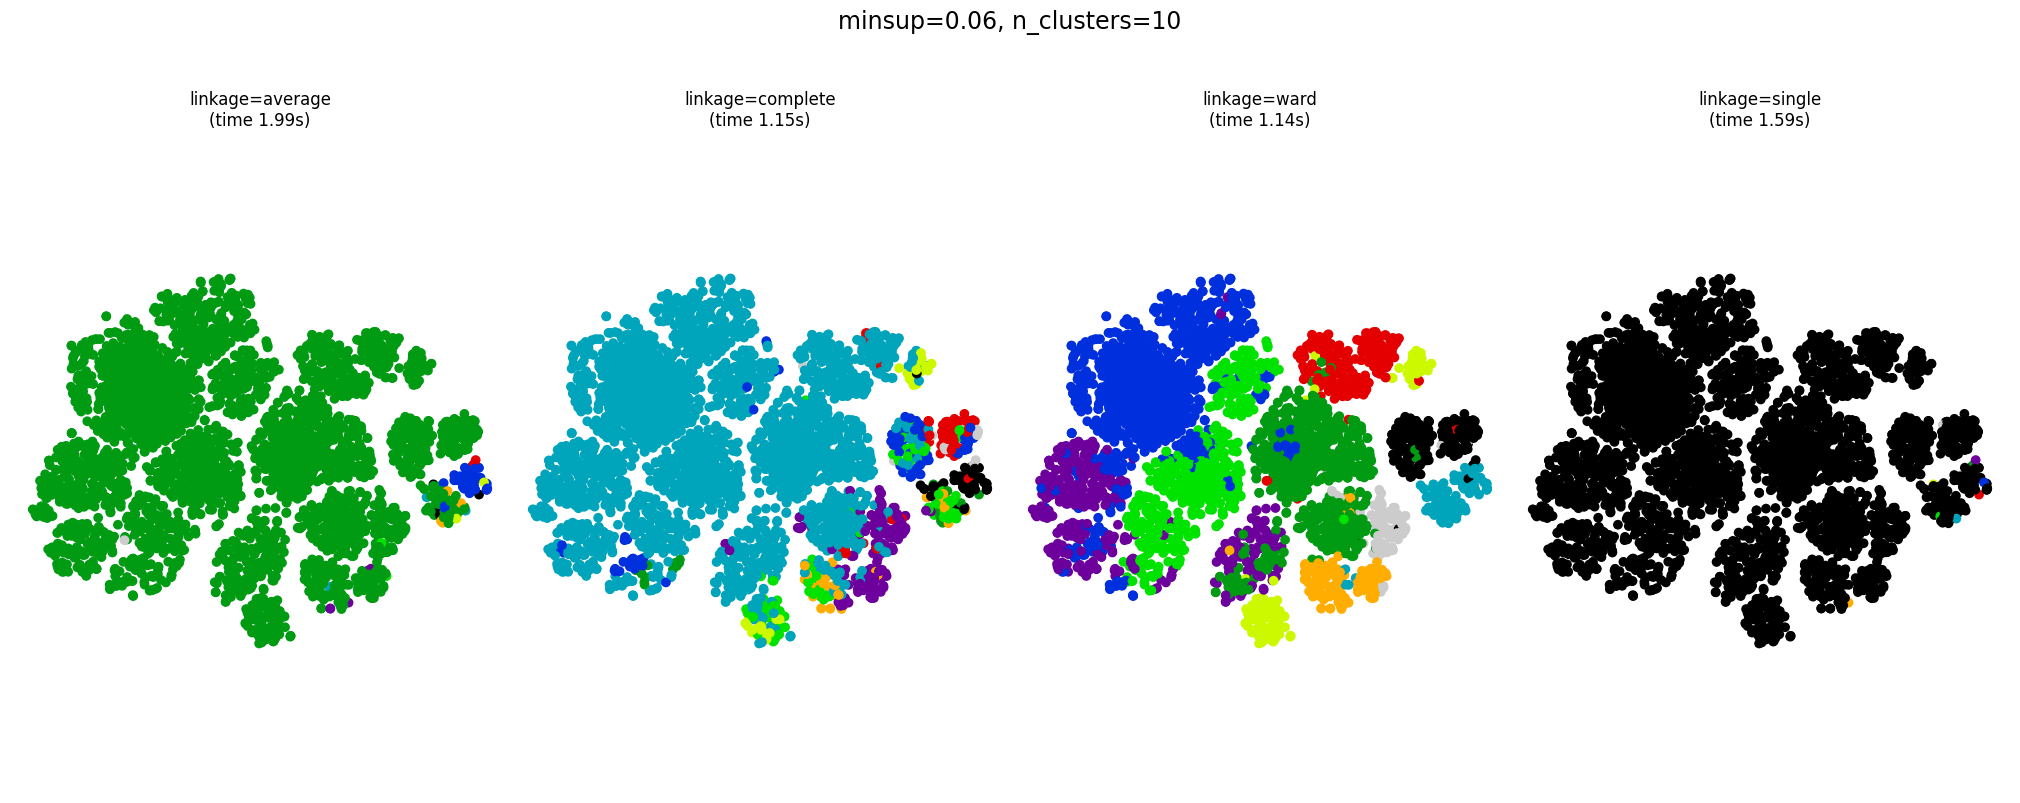

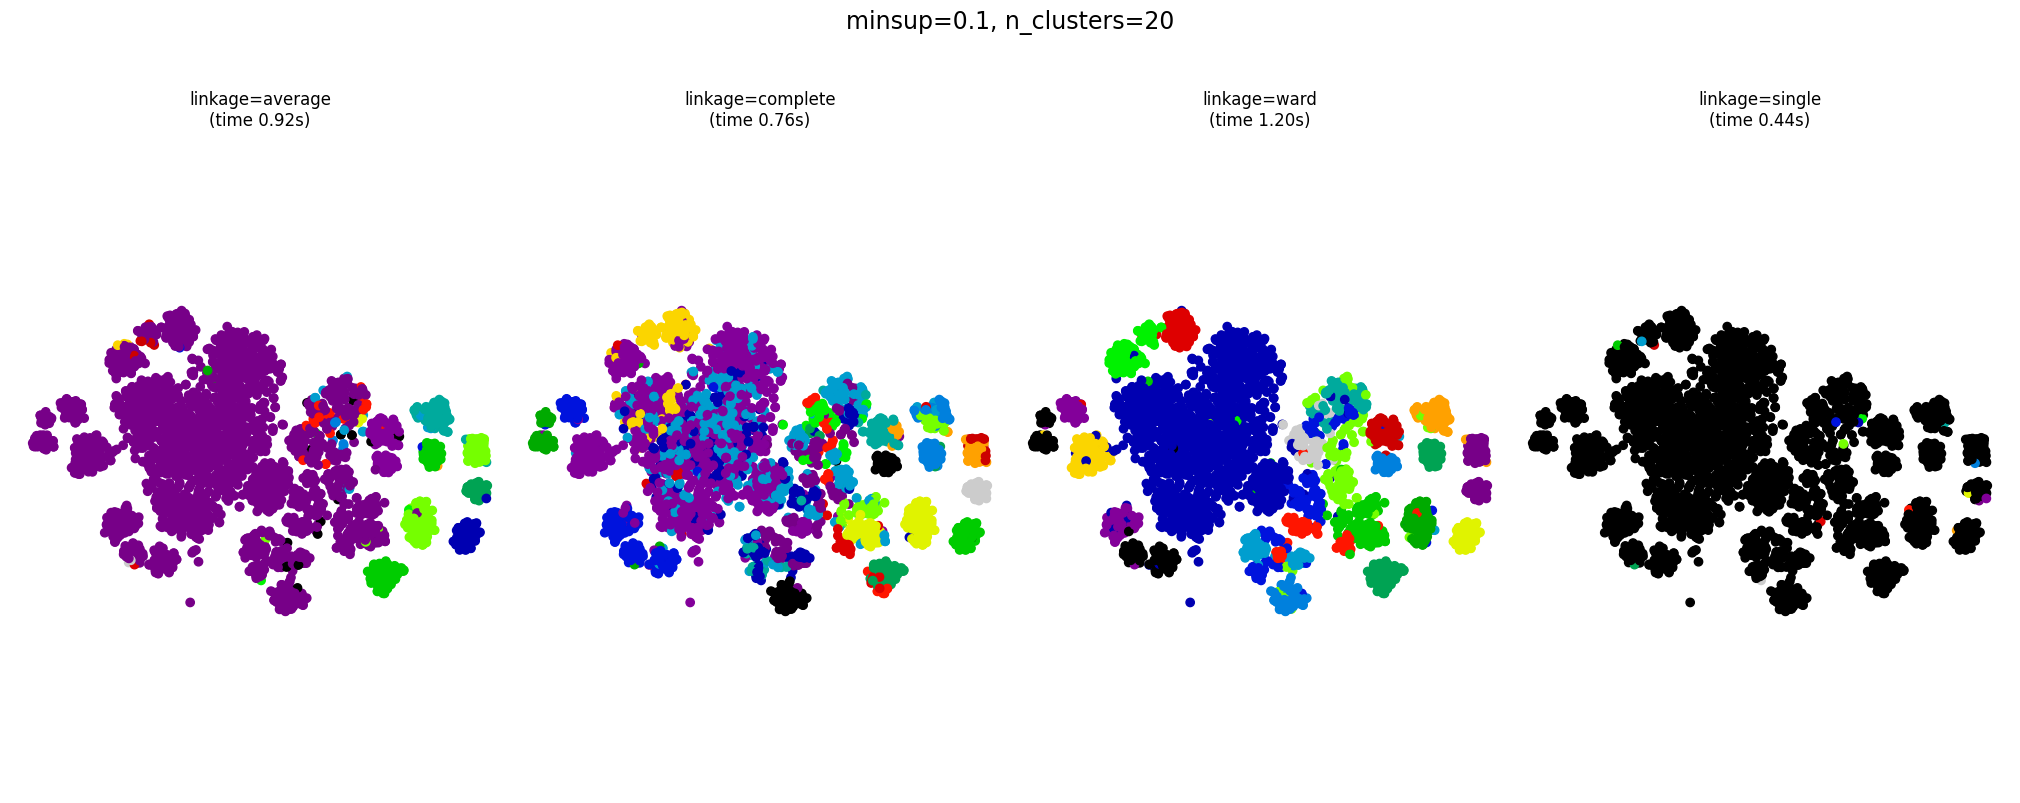

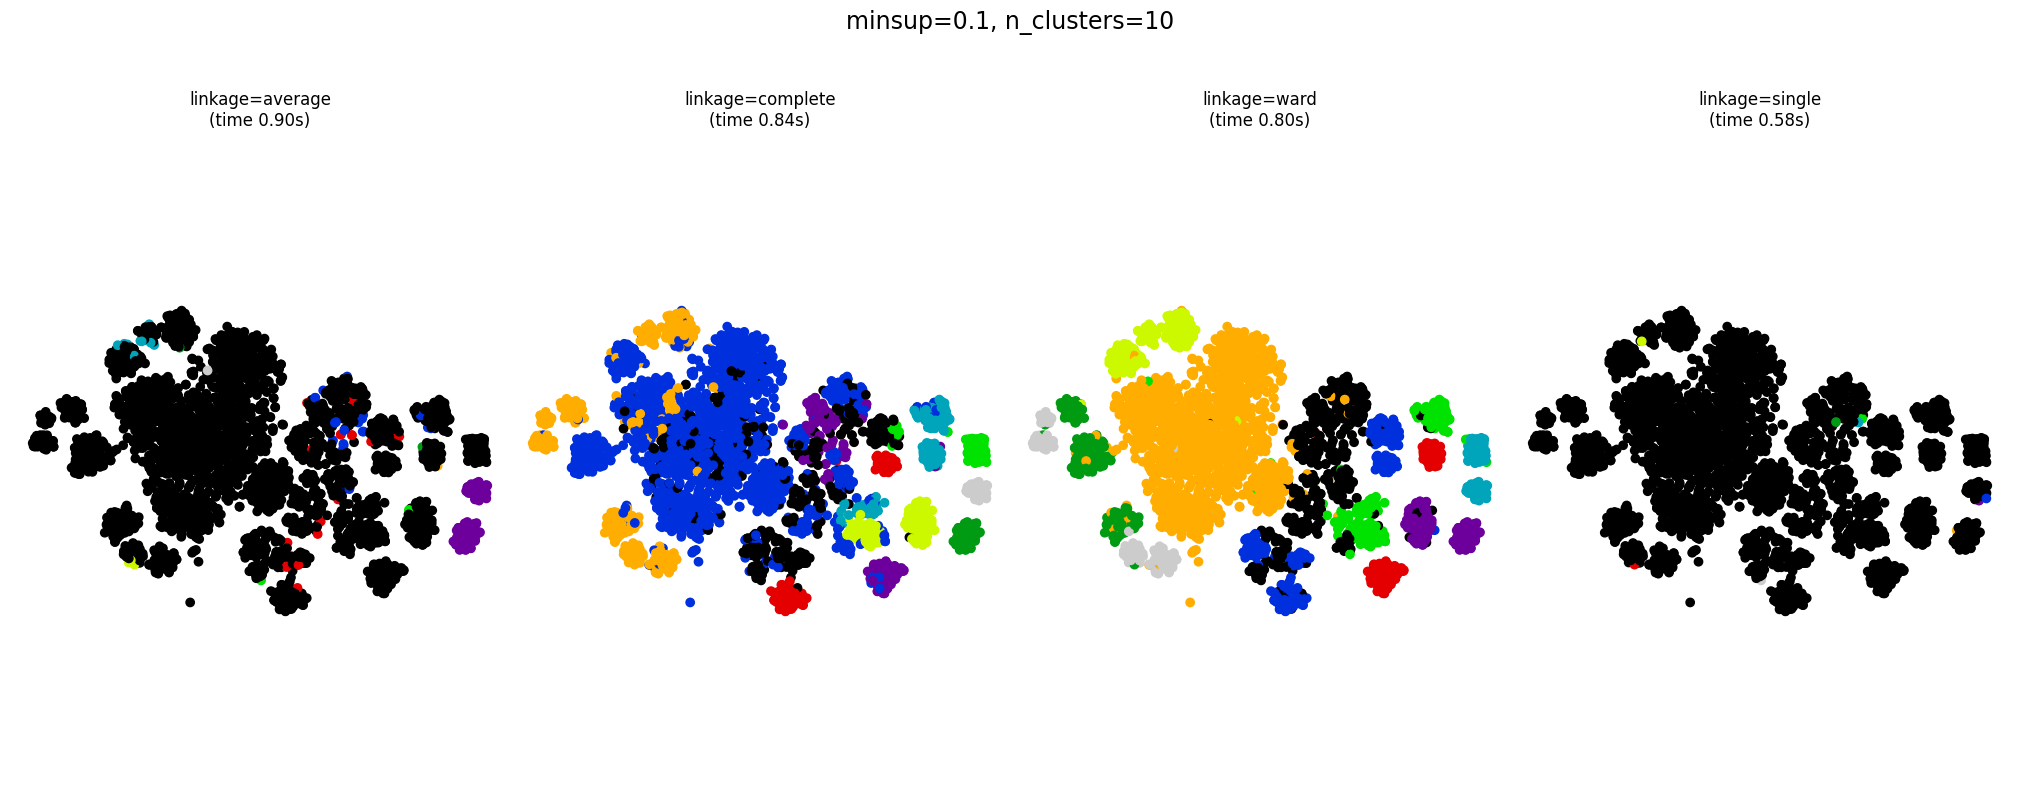

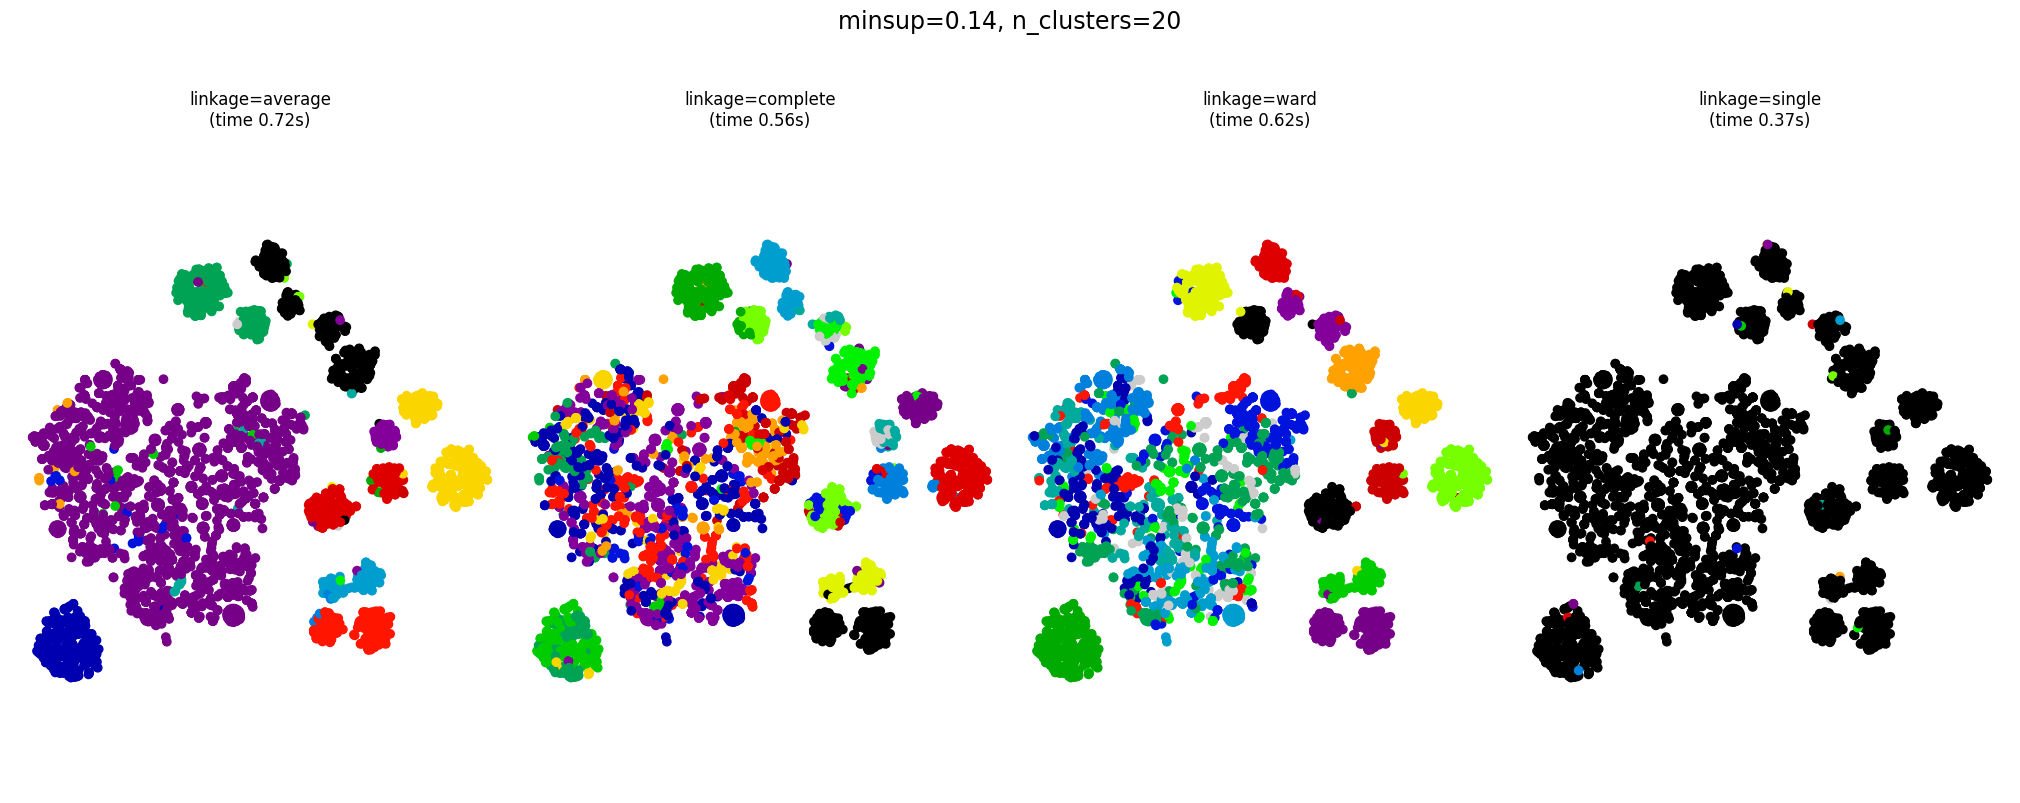

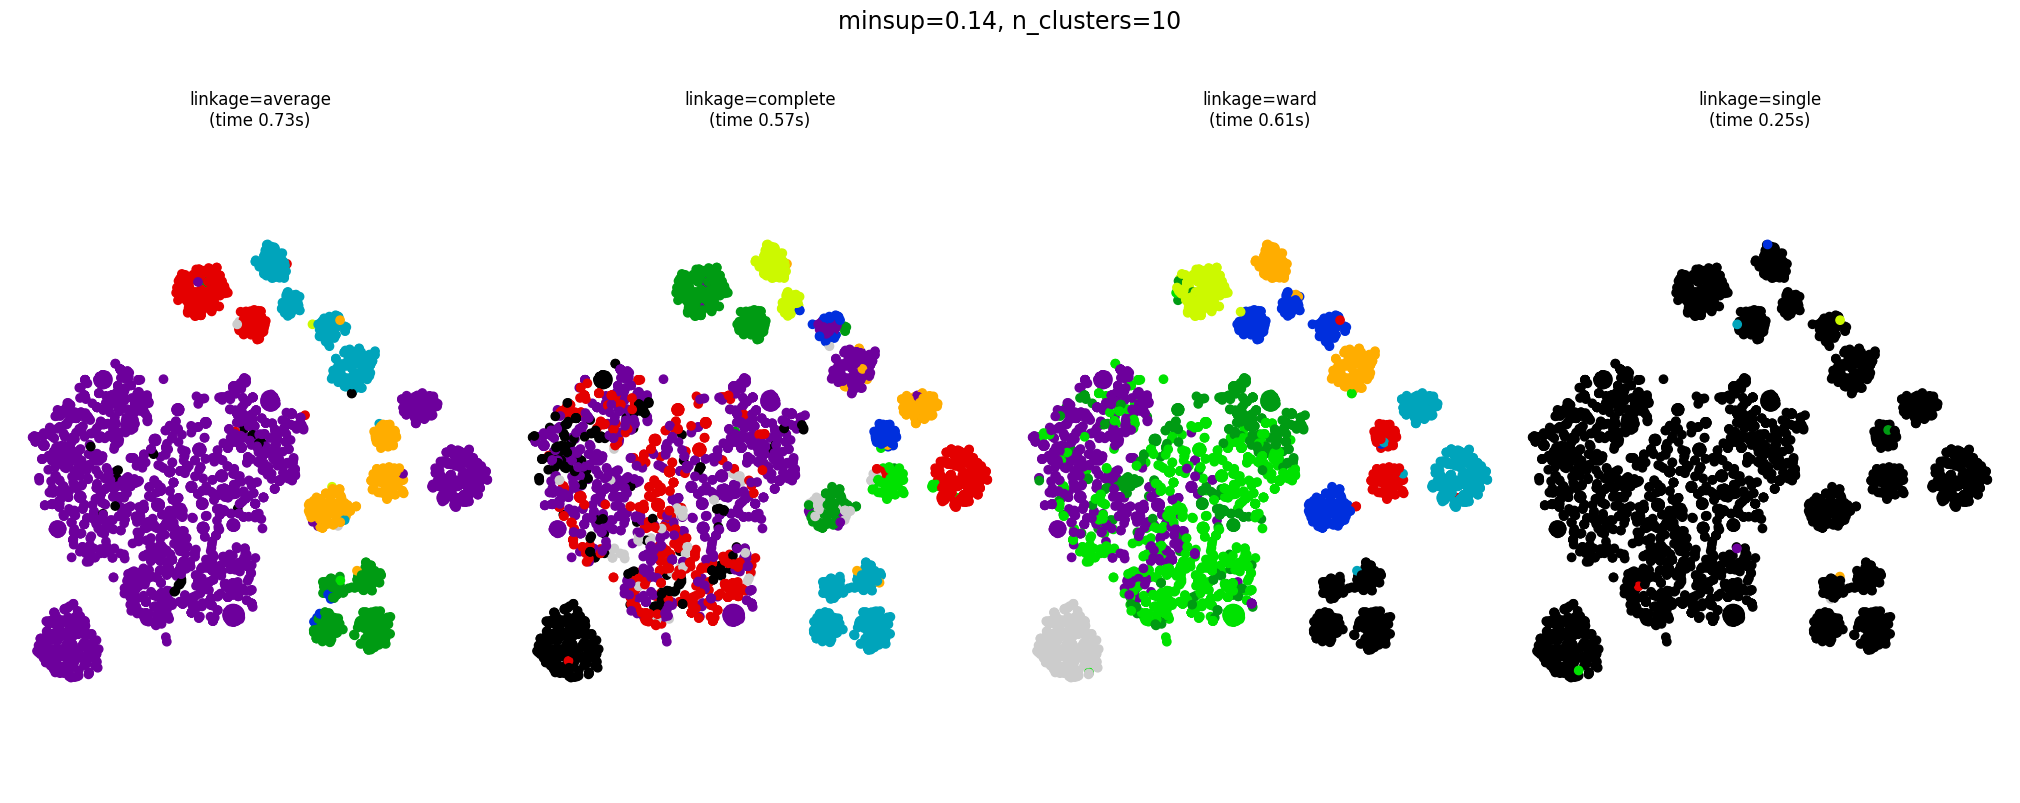

In [ ]:
import warnings
from sklearn import metrics

def hierarchical_clustering(groceries_onehot_csv_path, groceries_frequent_itemsets_per_minsup):
  # prepare to get labels for each iteration with different minsup and n_clusters
  labels_per_minsup_n_clusters = []

  groceries_onehot_df = pd.read_csv(groceries_onehot_csv_path)

  # Generating the input nparray for hierarchical clustering from
  # the groceries_onehot_df and the groceries_frequent_itemsets array from apriori

  for i in range(len(groceries_frequent_itemsets_per_minsup)):
    groceries_frequent_itemsets_list = [list(fs) for fs in groceries_frequent_itemsets_per_minsup[i]]
    if ['Unnamed: 0'] in groceries_frequent_itemsets_list:
      groceries_frequent_itemsets_list.remove(['Unnamed: 0'])

    print("groceries_frequent_itemsets, ", i"th ", "minsup")

    groceries_frequent_onehot_df = pd.DataFrame()
    for itemset in groceries_frequent_itemsets_list:
        if len(itemset) == 1:
            # For single-item itemsets
            groceries_frequent_onehot_df[itemset[0]] = groceries_onehot_df[itemset[0]].astype(int)
        else:
            # For multi-item itemsets, compute the logical AND of all items
            column_name = ' and '.join(itemset)

            # Suppress specific PerformanceWarning
            with warnings.catch_warnings():
              warnings.simplefilter("ignore", category=pd.errors.PerformanceWarning)
              groceries_frequent_onehot_df[column_name] = groceries_onehot_df[itemset].all(axis=1).astype(int)

    # Remove rows where all values are zero
    groceries_frequent_onehot_df = groceries_frequent_onehot_df[groceries_frequent_onehot_df.any(axis=1)]
    groceries_frequent_onehot_nparray = groceries_frequent_onehot_df.to_numpy()


    # fit model

    for n_clusters in (20, 10):
        plt.figure(figsize=(20, 8))
        for index, linkage in enumerate(("average", "complete", "ward", "single")):
            plt.subplot(1, 4, index + 1)
            model = AgglomerativeClustering(linkage=linkage, n_clusters=n_clusters)

            # Fit the model on the original high-dimensional data
            t0 = time.time()
            model.fit(groceries_frequent_onehot_nparray)

            metrics.calinski_harabasz_score(X, labels)
            metrics.silhouette_score(X, labels, metric='euclidean')
            labels_per_minsup_n_clusters.append(model.labels_)
            elapsed_time = time.time() - t0

            # Apply t-SNE for visualization
            n_samples = groceries_frequent_onehot_nparray.shape[0]
            tsne = TSNE(n_components=2, perplexity=min(30, n_samples-1), random_state=0)
            reduced_data_tsne = tsne.fit_transform(groceries_frequent_onehot_nparray)

            # Scatter plot for the t-SNE reduced data
            plt.scatter(reduced_data_tsne[:, 0], reduced_data_tsne[:, 1], c=model.labels_, cmap=plt.cm.nipy_spectral)
            plt.title("linkage=%s\n(time %.2fs)" % (linkage, elapsed_time), fontdict=dict(verticalalignment="top"))
            plt.axis("equal")
            plt.axis("off")

        plt.subplots_adjust(bottom=0, top=0.83, wspace=0, left=0, right=1)
        plt.suptitle("minsup=%s, n_clusters=%i" % (groceries_minsup_list[i], n_clusters), size=17)

        plt.show()
  return labels_per_minsup_n_clusters

groceries_labels_per_iteration = hierarchical_clustering("/content/drive/MyDrive/groceries_onehot.csv", groceries_frequent_itemsets_per_minsup)

##Ecommerce dataset (large dataset)


Apriori with different minsup on ecommerce dataset

In [ ]:
def process_ecommerce_data():
  # ecommerce dataset processing
  te = TransactionEncoder()

  ecommerce_data = pd.read_csv("/content/drive/MyDrive/CZ4032/Proj 2/ecommerce_oct_dataset.csv")
  filtered = ecommerce_data[ecommerce_data['category_code'].notna()]
  ecommerce_grouped = filtered.groupby("user_id", as_index=False).aggregate({"category_code": lambda x: list(set(x))})
  print(ecommerce_grouped)
  print(type(ecommerce_grouped['category_code'][0][0]))
  te_ary = te.fit(ecommerce_grouped["category_code"]).transform(ecommerce_grouped["category_code"])
  ecommerce_onehot = pd.DataFrame(te_ary, columns=te.columns_)
  print(ecommerce_onehot)

  ecommerce_onehot.to_csv("/content/drive/MyDrive/CZ4032/Proj 2/ecommerce_onehot.csv")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'\n# ecommerce dataset processing\nte = TransactionEncoder()\n\necommerce_data = pd.read_csv("/content/drive/MyDrive/CZ4032/Proj 2/ecommerce_oct_dataset.csv")\nfiltered = ecommerce_data[ecommerce_data[\'category_code\'].notna()]\necommerce_grouped = filtered.groupby("user_id", as_index=False).aggregate({"category_code": lambda x: list(set(x))})\nprint(ecommerce_grouped)\nprint(type(ecommerce_grouped[\'category_code\'][0][0]))\nte_ary = te.fit(ecommerce_grouped["category_code"]).transform(ecommerce_grouped["category_code"])\necommerce_onehot = pd.DataFrame(te_ary, columns=te.columns_)\nprint(ecommerce_onehot)\n\necommerce_onehot.to_csv("/content/drive/MyDrive/CZ4032/Proj 2/ecommerce_onehot.csv")\n\n# unused chunk version\n"""\necommerce_data_iter = pd.read_csv("/content/drive/MyDrive/CZ4032/Proj 2/ecommerce_oct_dataset.csv", chunksize=10000)\nfor chunk in ecommerce_data_iter:\n  filtered_chunk = chunk[chunk[\'category_code\'].notna()]\n  ecommerce_grouped = filtered_chunk.groupby("user_

In [ ]:
def large_dataset_apriori_with_different_minsup(ecommerce_onehot_csv_path):
  # run apriori (low memory version) on ecommerce dataset with multiple minsup values
  minsup_list = [0.04, 0.08, 0.12]
  ecommerce_frequent_items_per_minsup = []
  for minsup in minsup_list:
    ecommerce_frequent_items_per_minsup.append(apriori(ecommerce_onehot_csv_path, minsup))

  return ecommerce_frequent_items_per_minsup

ecommerce_frequent_items_per_minsup = large_data set_apriori_with_different_minsup("/content/drive/MyDrive/CZ4032/Proj 2/ecommerce_onehot.csv")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-26-1c652a5a8b59>:18: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for (column_name, rows) in data.iteritems():
<ipython-input-26-1c652a5a8b59>:18: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for (column_name, rows) in data.iteritems():
<ipython-input-26-1c652a5a8b59>:18: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for (column_name, rows) in data.iteritems():
<ipython-input-26-1c652a5a8b59>:18: FutureWarning: iteritems is deprecated and will be removed i

In [ ]:
ecommerce_frequent_items_per_minsup

[[frozenset({'Unnamed: 0'}),
  frozenset({'apparel.shoes'}),
  frozenset({'appliances.environment.vacuum'}),
  frozenset({'appliances.kitchen.refrigerators'}),
  frozenset({'appliances.kitchen.washer'}),
  frozenset({'computers.notebook'}),
  frozenset({'electronics.audio.headphone'}),
  frozenset({'electronics.clocks'}),
  frozenset({'electronics.smartphone'}),
  frozenset({'electronics.video.tv'}),
  frozenset({'electronics.audio.headphone', 'electronics.smartphone'}),
  frozenset({'electronics.clocks', 'electronics.smartphone'})],
 [frozenset({'Unnamed: 0'}),
  frozenset({'electronics.audio.headphone'}),
  frozenset({'electronics.clocks'}),
  frozenset({'electronics.smartphone'})],
 [frozenset({'Unnamed: 0'}), frozenset({'electronics.smartphone'})]]

#ignore below

In [ ]:
#Getting frequent itemset for Groceries using mlxtend's apriori function.
from mlxtend.frequent_patterns import apriori

groceries_df = pd.read_csv("/content/drive/MyDrive/groceries_dataset.csv")
groceries = groceries_df.groupby("Member_number", as_index=False).aggregate({"itemDescription": lambda x: list(set(x))})
te = TransactionEncoder()
te_ary = te.fit(groceries["itemDescription"]).transform(groceries["itemDescription"])
te_ary = te_ary.astype("int") #convert to binary (1s and 0s)
groceries_onehot_df = pd.DataFrame(te_ary, columns=te.columns_) # needed for hierarchical clustering

groceries_minsup_list = [0.1, 0.15, 0.2]
groceries_frequent_itemsets_per_minsup = []
for minsup in groceries_minsup_list:
  groceries_frequent_itemsets_per_minsup.append(apriori(groceries_onehot_df, min_support = minsup, use_colnames = True)) # needed for hierarchical clustering

/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [ ]:
groceries_frequent_itemsets_per_minsup[2]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,support,itemsets
0,0.213699,(bottled water)
1,0.376603,(other vegetables)
2,0.349666,(rolls/buns)
3,0.230631,(root vegetables)
4,0.206003,(sausage)
5,0.313494,(soda)
6,0.233710,(tropical fruit)
7,0.458184,(whole milk)
8,0.282966,(yogurt)


In [ ]:
# Generating the input nparray for hierarchical clustering from
# the groceries_onehot_df and the groceries_frequent_itemsets array from apriori

# using minsup = 0.2
groceries_frequent_itemsets_list = []
for index,value in groceries_frequent_itemsets_per_minsup[2]['itemsets'].items():
  groceries_frequent_itemsets_list.append(list(value))#converting frequent itemsets to a list

groceries_frequent_onehot_df = pd.DataFrame(index=groceries_frequent_itemsets_per_minsup[1].index)

for itemset in groceries_frequent_itemsets_list:
    if len(itemset) == 1:
        # For single-item itemsets
        groceries_frequent_onehot_df[itemset[0]] = groceries_onehot_df[itemset[0]].astype(int)
    else:
        # For multi-item itemsets, compute the logical AND of all items
        column_name = ' and '.join(itemset)
        groceries_frequent_onehot_df[column_name] = groceries_onehot_df[itemset].all(axis=1).astype(int)

# Remove rows where all values are zero
groceries_frequent_onehot_df = groceries_frequent_onehot_df[groceries_frequent_onehot_df.any(axis=1)]

groceries_frequent_onehot_nparray = groceries_frequent_onehot_df.to_numpy()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print(groceries_frequent_itemsets_list)
print(groceries_frequent_onehot_df)

[['bottled water'], ['other vegetables'], ['rolls/buns'], ['root vegetables'], ['sausage'], ['soda'], ['tropical fruit'], ['whole milk'], ['yogurt']]
    bottled water  other vegetables  rolls/buns  root vegetables  sausage  \
0               0                 0           0                0        1   
1               0                 0           1                0        1   
2               0                 1           0                0        0   
3               0                 0           1                1        1   
4               0                 1           1                1        0   
5               0                 0           1                0        0   
6               1                 0           1                0        0   
7               0                 0           0                1        0   
8               0                 0           0                0        0   
9               1                 0           1                0        0   
10 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE

for n_clusters in (10, 8, 6, 4):
    plt.figure(figsize=(20, 8))
    for index, linkage in enumerate(("average", "complete", "ward", "single")):
        plt.subplot(1, 4, index + 1)
        model = AgglomerativeClustering(linkage=linkage, n_clusters=n_clusters)

        # Fit the model on the original high-dimensional data
        t0 = time.time()
        model.fit(groceries_frequent_onehot_nparray)
        elapsed_time = time.time() - t0

        # Apply t-SNE for visualization
        n_samples = groceries_frequent_onehot_nparray.shape[0]
        tsne = TSNE(n_components=2, perplexity=min(30, n_samples-1), random_state=0)
        reduced_data_tsne = tsne.fit_transform(groceries_frequent_onehot_nparray)

        # Scatter plot for the t-SNE reduced data
        plt.scatter(reduced_data_tsne[:, 0], reduced_data_tsne[:, 1], c=model.labels_, cmap=plt.cm.nipy_spectral)
        plt.title("linkage=%s\n(time %.2fs)" % (linkage, elapsed_time), fontdict=dict(verticalalignment="top"))
        plt.axis("equal")
        plt.axis("off")

    plt.subplots_adjust(bottom=0, top=0.83, wspace=0, left=0, right=1)
    plt.suptitle("n_clusters=%i" % n_clusters, size=17)
    plt.show()
